<a href="https://colab.research.google.com/github/yonatanlou/notebooks/blob/main/hierarchical_clustering_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating Hierarchical Clustering Beyond the Leaves 🌳
When working on hierarchical clustering tasks, evaluation is often limited to the **leaves of the tree** or relies on plots that look impressive but don't tell the whole story.What if we could assess the entire tree structure? Wouldn't that give us a more nuanced view of our clustering methods, linkage techniques, or embedding models?

In this short article, I'll introduce you to a clever method invented by **Sanjoy Dasgupta** for evaluating hierarchical clustering—not just at the leaves but across the whole tree structure.

Most people who implement hierarchical clustering tend to evaluate it using well-known unsupervised learning metrics (like the ones mentioned in [scikit-learn's clustering evaluation](https://scikit-learn.org/1.5/modules/clustering.html#clustering-performance-evaluation)).  
These metrics typically require you to "flatten" the clusters. In other words, they convert your hierarchical structure into a flat list of cluster assignments \( f(\hat{y}, y) \). When that happens, all the benefits of hierarchical clustering go straight out the window.

Let's say you have a dataset organized into **three levels of hierarchy**. If an object ends up in the wrong cluster at the **third level** (the lowest), is it really wrong? What if it's correctly grouped at the **second level**? That's valuable information you lose when you flatten everything into a single level.


If you're new to hierarchical clustering, I highly recommend checking out [Jörn's Blog](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Inconsistency-Method)

### Dasgupta's Cost Function
Dasgupta's cost function is designed to capture exactly that nuance. Instead of evaluating only the leaves, it evaluates the clustering across all levels of the hierarchy. In essence, it measures how well the structure of your tree reflects the underlying similarities in your data.


#### **Input:**  
In Dasgupta's formulation, the input to a clustering problem consists of similarity scores between certain pairs of elements, represented as an **undirected graph** \( G = (V, E) \), with the elements as its vertices and non-negative real weights on its edges.


#### **Cost Function Definition:**  
A hierarchical clustering can be described as a **tree** (not necessarily a binary tree) whose **leaves** are the elements to be clustered. The clusters are then the subsets of elements descending from each tree node.  
The **size** \( |C| \) of any cluster \( C \) is the number of elements in the cluster.

For each edge \( uv \) of the input graph:
- Let \( w(uv) \) denote the **weight** of edge \( uv \).
- Let \( C(uv) \) denote the **smallest cluster** of a given clustering that contains both \( u \) and \( v \).

Then Dasgupta defines the **cost of a clustering** as:

$$
\sum_{uv \in E} w(uv) \cdot |C(uv)|
$$



#### **Intuition:**  
It is better to cut a high-similarity edge at a lower level.


For a clear example, check out this presentation from [IRIF](https://www.irif.fr/_media/users/claire/talkcolle_gedefrance7juin2018.pdf).  

Also, [Benjamin Perret](https://perso.esiee.fr/~perretb/) has implemented this objective in an easy-to-use [Python package](https://higra.readthedocs.io/en/stable/python/hierarchical_cost.html). 🎉


I will show here a nice example with hierarchial text clustering for items from Amazon.


In [1]:
try:
  import sknetwork
except:
  !pip install scikit-network

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [12]:
import os
import random

import pandas as pd
from tqdm.notebook import tqdm
import numpy as np


from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
import kagglehub

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sknetwork.hierarchy import dasgupta_score
from sklearn.metrics import confusion_matrix, silhouette_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
warnings.filterwarnings("ignore")
FIGS_PATH = "/content/gdrive/MyDrive/Colab Notebooks/hierarchical-clustering-eval_files"
os.makedirs(FIGS_PATH, exist_ok=True)
def set_seed_globally(seed=42):
    # Set seeds
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed_globally(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

path = kagglehub.dataset_download("lokeshparab/amazon-products-dataset")

# print("Path to dataset files:", path)

csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
dfs = []
for file in csv_files:
    file_path = os.path.join(path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)
combined_df = pd.concat(dfs, ignore_index=True)

This dataset contains only **two levels** of hierarchy, so I created an additional level to enrich the structure.

By adding this third level, the hierarchy becomes more informative and allows for a deeper evaluation of clustering performance across multiple granularities.

In [4]:
categories = {
    "Fashion and Accessories": [
        "men's shoes", "men's clothing", "women's shoes",
        "women's clothing", "kids' fashion", "bags & luggage", "accessories"
    ],
    "Home and Lifestyle": [
        "home, kitchen, pets", "home & kitchen", "appliances", "pet supplies"
    ],
    "Health and Entertainment": [
        "beauty & health", "music", "tv, audio & cameras", "sports & fitness"
    ],
    "Family and General Supplies": [
        "grocery & gourmet foods", "toys & baby products", "car & motorbike",
        "industrial supplies", "stores"
    ]
}
mapping = {sub_cat: main_cat for main_cat, sub_cats in categories.items() for sub_cat in sub_cats}
combined_df["1st_level_category"] = combined_df["main_category"].map(mapping).fillna("Unknown")
combined_df = combined_df.rename(columns={
    "main_category": "2nd_level_category",
    "sub_category": "3rd_level_category"
})

combined_df.groupby(["1st_level_category", "2nd_level_category"])["3rd_level_category"].nunique()

1st_level_category           2nd_level_category     
Family and General Supplies  car & motorbike             6
                             grocery & gourmet foods     3
                             industrial supplies         4
                             stores                      6
                             toys & baby products        9
Fashion and Accessories      accessories                 7
                             bags & luggage              6
                             kids' fashion               6
                             men's clothing              4
                             men's shoes                 3
                             women's clothing            4
                             women's shoes               3
Health and Entertainment     beauty & health             8
                             music                       1
                             sports & fitness           12
                             tv, audio & cameras         9
Home and Lifestyle           appliances                  6
                             home & kitchen             12
                             home, kitchen, pets         1
                             pet supplies                2
Name: 3rd_level_category, dtype: int64

In [5]:
N_SAMPLES = 100
df = combined_df[["name", "1st_level_category", "2nd_level_category", "3rd_level_category"]]
df = df.sample(N_SAMPLES)
df.head()

,name,1st_level_category,2nd_level_category,3rd_level_category
728311,Metro Womens Synthetic Antic Gold Slip Ons (Si...,Fashion and Accessories,women's shoes,Fashion Sandals
123190,Beingelegant - Pack of 100 Women's Organza Net...,Fashion and Accessories,accessories,Bags & Luggage
772828,Wolven Handcrafted Men's Termoli Black Burnish...,Fashion and Accessories,men's shoes,Formal Shoes
979017,GROOT Party Wedding Analog Black Color Dial Me...,Fashion and Accessories,accessories,Watches
295506,Happy Cultures Girls and Women Handmade Croche...,Fashion and Accessories,accessories,Handbags & Clutches


So now, we have a nice dataset with three levels of hierarchy.  

For this experiment, I won't focus on text processing, but I believe that it could be beneficial for future improvements.

There are two main choices we need to make for this task:  

1. **How do we vectorize (embed) the item names?**
   Should we use simple vectorizers like TF-IDF or more advanced embeddings like BERT (maybe compare multiple BERT models)? The choice of embedding can have a significant impact on the clustering quality.

2. **How do we evaluate?**  
   Do we stick to standard metrics like silhouette score or adjusted Rand index, or should we use tree-aware methods like Dasgupta's cost function to assess the full hierarchy?


Actually, there are much more decisions to make, such as the right linkage method, parameters for the embedding method, etc, but we will stay lean in this article.

### Embeddings Generation

For this experiment, I chose to use three simple embedding models:

1. **Bag of Words (BOW)** - a classic method that represents text by counting word occurrences.  
2. **BERT** - specifically the [paraphrase-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2) model, which provides contextual embeddings that capture semantic meaning.  
3. **TF-IDF** - a method that balances word frequency by down-weighting common words and up-weighting more informative ones.  


In [6]:
bert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
bert_model.to(device)

def generate_embeddings(texts, method="tf-idf", vectorizer_params=None):
    vectorizer_params = vectorizer_params or {}

    if method == "n-gram":
        vectorizer = CountVectorizer(**vectorizer_params)
        embeddings = vectorizer.fit_transform(texts).toarray()

    elif method == "tf-idf":
        vectorizer = TfidfVectorizer(**vectorizer_params)
        embeddings = vectorizer.fit_transform(texts).toarray()

    elif method == "bert":
        torch.cuda.empty_cache()
        embeddings = bert_model.encode(texts, show_progress_bar=False, device=device)


    else:
        raise ValueError("Invalid method. Choose from 'n-gram', 'tf-idf', 'bert'.")

    return embeddings

vectorizer_params = {"ngram_range": (1, 1), "max_features": 1000, "analyzer":"word"}
embeddings = generate_embeddings(df["name"].to_list(), method="n-gram", vectorizer_params=vectorizer_params)

### Hierarchical clustering

In [7]:
def perform_hierarchical_clustering(embeddings, method="ward"):
    if not isinstance(embeddings, np.ndarray):
        raise ValueError("Embeddings must be a NumPy array.")

    linkage_matrix = linkage(embeddings, method=method)
    return linkage_matrix

def generate_predictions(embeddings, method="hierarchical", num_clusters=20, linkage_matrix=None):
    if method == "kmeans":
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        labels = kmeans.fit_predict(embeddings)

    elif method == "hierarchical":
        if linkage_matrix is None:
            raise ValueError("Linkage matrix must be provided for hierarchical clustering.")
        labels = fcluster(linkage_matrix,num_clusters,  criterion='maxclust')

    else:
        raise ValueError("Invalid method. Choose from 'kmeans' or 'hierarchical'.")

    return labels.astype(int)



### Evaluation
#### Classical unsupervised clustering evaluation

In [8]:
def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    total_correct = cm[row_ind, col_ind].sum()
    total_samples = cm.sum()
    accuracy = total_correct / total_samples

    return accuracy

def evaluate_flat_clustering(embeddings, labels_true, labels_pred, metric="silhouette"):
    if metric == "silhouette":
        score = silhouette_score(embeddings, labels_true)
    elif metric == "adjusted_rand":
        #Requires ground truth labels for adjusted_rand_score
        if labels_true is None:
            raise ValueError("Adjusted Rand Index requires ground truth labels.")
        score = adjusted_rand_score(labels_true, labels_pred)
    elif metric == "clustering_accuracy":
        score = clustering_accuracy(labels_true, labels_pred)
    else:
        raise ValueError("Invalid metric. Choose from 'silhouette', 'adjusted_rand'.")

    return score

#### Dasgupta Objective

For the Dasgupta objective, we need a linkage method and a similarity matrix between different items.  

This similarity matrix can be constructed in various ways. For this experiment, I decided to build it as follows:
- Items in the lowest level of the hierarchy get 1 point.  
- Items in the middle level get 0.5 points.  
- Items in the highest level get 0.25 points.  

This scoring reflects the idea that closely related items (at the lowest level) should have a higher similarity score than those grouped at broader levels.

To better visualize this, here's the heatmap for the similarity matrix of the first 10 items:


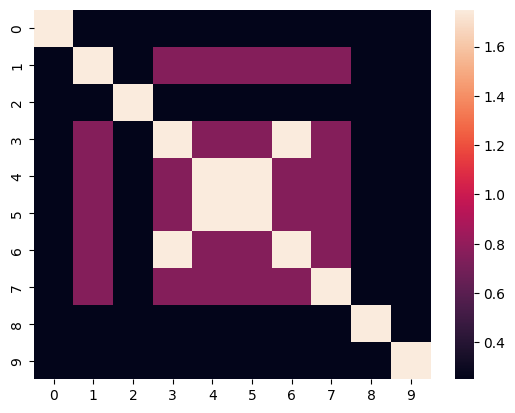

In [13]:
def create_adjacency_matrix(df):
    if not all(col in df.columns for col in ['1st_level_category', '2nd_level_category', '3rd_level_category']):
        raise ValueError("The DataFrame must contain '1st_level_category', '2nd_level_category', and '3rd_level_category' columns.")

    n = len(df)
    adjacency_matrix = np.zeros((n, n))

    # Precompute category matches
    third_level_match = (df['3rd_level_category'].values[:, None] == df['3rd_level_category'].values).astype(float)
    second_level_match = (df['2nd_level_category'].values[:, None] == df['2nd_level_category'].values).astype(float)
    first_level_match = (df['1st_level_category'].values[:, None] == df['1st_level_category'].values).astype(float)

    # Compute scores
    adjacency_matrix += third_level_match
    adjacency_matrix += 0.5 * second_level_match
    adjacency_matrix += 0.25 * first_level_match

    np.fill_diagonal(adjacency_matrix, 1.75)
    assert adjacency_matrix.shape == (n, n)
    return adjacency_matrix

adjacency_matrix = create_adjacency_matrix(df)
fig = sns.heatmap(adjacency_matrix[:10,:10])
plt.savefig(f"{FIGS_PATH}/adj_mat.png", transparent=True)


In [14]:
df.reset_index(drop=True).head(10)

,name,1st_level_category,2nd_level_category,3rd_level_category
0,Metro Womens Synthetic Antic Gold Slip Ons (Si...,Fashion and Accessories,women's shoes,Fashion Sandals
1,Beingelegant - Pack of 100 Women's Organza Net...,Fashion and Accessories,accessories,Bags & Luggage
2,Wolven Handcrafted Men's Termoli Black Burnish...,Fashion and Accessories,men's shoes,Formal Shoes
3,GROOT Party Wedding Analog Black Color Dial Me...,Fashion and Accessories,accessories,Watches
4,Happy Cultures Girls and Women Handmade Croche...,Fashion and Accessories,accessories,Handbags & Clutches
5,ZOUK Women's Handcrafted Ikat Shoulder Tote Ba...,Fashion and Accessories,accessories,Handbags & Clutches
6,NEUTRON Present Analog Orange and Blue Color D...,Fashion and Accessories,accessories,Watches
7,PC Jeweller The Giancarlo 18KT White Gold and ...,Fashion and Accessories,accessories,Gold & Diamond Jewellery
8,Blue/Black Light wash 5-Pocket Slim Fit high-R...,Fashion and Accessories,men's clothing,Jeans
9,KBNBJ Women's Pure Cotton Regular Nighty,Fashion and Accessories,women's clothing,Lingerie & Nightwear


We can see that some of the items share exactly the same clusters across all levels of the hierarchy. These items receive the maximum score of 1.  

Some items differ in only one or two levels, resulting in intermediate scores like 0.5 or 0.25.  

Finally, there are pairs of items that have nothing in common across all levels, so their similarity score is 0.  


#### Comparison
Let's compare the different embedding models by analyzing their dendrograms and the corresponding scores we calculated.


In [15]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
def evaluate_clustering(df, vectorizer, vectorizer_params, level_for_eval):

  embeddings = generate_embeddings(df["name"].to_list(), method=vectorizer, vectorizer_params=vectorizer_params)
  linkage_matrix = perform_hierarchical_clustering(embeddings, method="ward")
  pred_labels = generate_predictions(embeddings, method="hierarchical",
                                      num_clusters=df[level_for_eval].nunique(),
                                      linkage_matrix=linkage_matrix)

  le = LabelEncoder()
  true_labels = le.fit_transform(df[level_for_eval].to_list())

  silhouette = evaluate_flat_clustering(embeddings, true_labels, pred_labels, metric="silhouette")
  clustering_accuracy_score = evaluate_flat_clustering(embeddings, true_labels, pred_labels, metric="clustering_accuracy")
  ari = evaluate_flat_clustering(embeddings, true_labels, pred_labels, metric="adjusted_rand")

  adjacency_matrix = create_adjacency_matrix(df)
  dasgupta = dasgupta_score(adjacency_matrix, linkage_matrix)
  c, coph_dists = cophenet(linkage_matrix, pdist(embeddings))
  metrics = {"silhouette": silhouette, "clustering_accuracy_score": clustering_accuracy_score, "ari": ari, "dasgupta": dasgupta, "cophenet": c}
  return metrics, linkage_matrix

def round_metrics(metrics, n=3):
  for key, value in metrics.items():
    metrics[key] = round(value, n)
  return metrics



In [16]:
df = combined_df[["name", "1st_level_category", "2nd_level_category", "3rd_level_category"]]

n_iters = 20
N_SAMPLES_EVAL = 1000
results = []
vectorizers = {"n-gram": {"ngram_range": (1, 1), "max_features": 10000, "analyzer":"word"},
               "bert": None,
               "tf-idf": {"max_features": 10000}}

for vectorizer, vectorizer_params in tqdm(vectorizers.items(), desc="vectorizers"):
  print(f"Evaluating {vectorizer}")
  for i in tqdm(range(n_iters), desc="iters"):

    df_sampled = df.sample(N_SAMPLES_EVAL,random_state=i)
    metrics_1st, linkage_matrix = evaluate_clustering(df_sampled, vectorizer, vectorizer_params, "1st_level_category")
    metrics_2nd, linkage_matrix = evaluate_clustering(df_sampled, vectorizer, vectorizer_params, "2nd_level_category")
    metrics_3rd, linkage_matrix = evaluate_clustering(df_sampled, vectorizer, vectorizer_params, "3rd_level_category")

    results.append({"vectorizer": vectorizer, "i": i, "eval_level": "1st", **metrics_1st})
    results.append({"vectorizer": vectorizer, "i": i, "eval_level": "2nd", **metrics_2nd})
    results.append({"vectorizer": vectorizer, "i": i, "eval_level": "3rd", **metrics_3rd})

comparison_df = pd.DataFrame(results)
comparison_df.to_csv("comparison_df.csv", index=False)


vectorizers:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating n-gram


iters:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating bert


iters:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating tf-idf


iters:   0%|          | 0/20 [00:00<?, ?it/s]

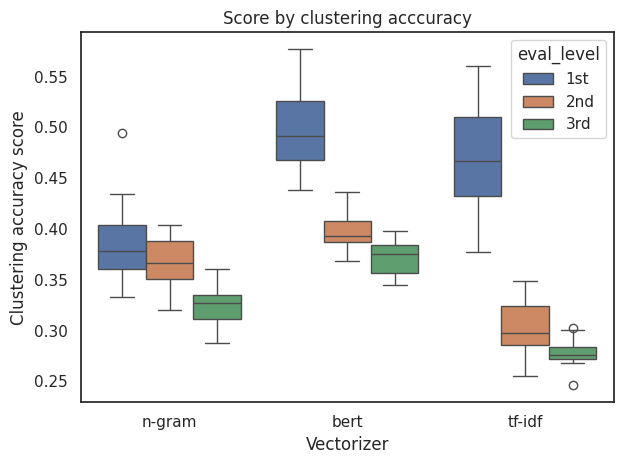

In [17]:
sns.set_theme(style="white")
sns.boxplot(data=comparison_df, x="vectorizer", y="clustering_accuracy_score", hue="eval_level")
plt.xlabel("Vectorizer")
plt.ylabel("clustering_accuracy_score".replace("_", " ").capitalize())
plt.title("Score by clustering acccuracy")
plt.tight_layout()
plt.savefig(f"{FIGS_PATH}/clustering_accuracy.png", transparent=True)
plt.show()

Yes, it's pretty hard to make sense of everything at first glance.  
First of all, we can see that the BERT model performs the best across all evaluation levels.  

But what if we want to compare n-grams and TF-IDF?  
For the accuracy metric, it seems that TF-IDF performs better at the 1st level, but performs worse at the other levels.  

The Dasgupta score provides a single score for all levels by taking into account the overall cost we defined earlier. This allows us to evaluate the entire hierarchy in a more holistic way, rather than focusing on individual levels.  

This approach makes it easier to compare different embedding models and understand how they perform across the full tree structure.

Text(0.5, 1.0, 'Score by dasgupta')

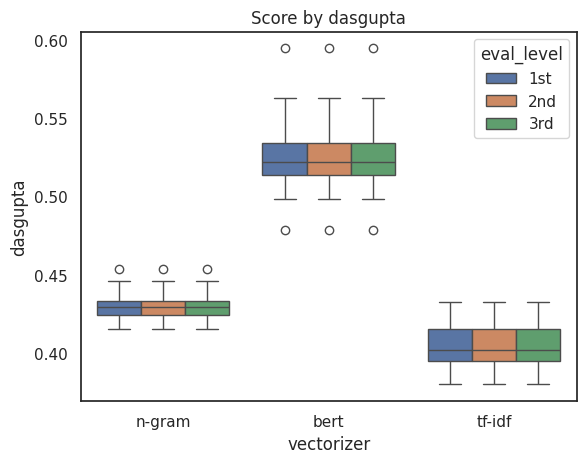

In [18]:

sns.boxplot(data=comparison_df, x="vectorizer", y="dasgupta", hue="eval_level")
plt.savefig(f"{FIGS_PATH}/dasgupta.png", transparent=True)
plt.title("Score by dasgupta")

#### Dendrogram

While it's really hard to read a dendrogram with more than ~100 points, it remains an important tool for evaluation and for ensuring that the clustering results align with our expectations.

Dendrograms allow us to visually inspect how items are grouped at different levels of the hierarchy, which can reveal unexpected patterns or potential issues.

Let's try to compare the dendrograms of BERT and TF-IDF side-by-side to see how they differ. By observing them "by eye," we can get a sense of how the embedding models influence the structure of the hierarchy.


In [19]:
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram


def colored_dendrogram(df, linkage_matrix, label_level, color_level):

    unique_categories = df[color_level].unique()
    num_colors = len(unique_categories)
    colormap = cm.get_cmap('tab20c', num_colors)  # Use HSV colormap for vibrant colors

        # Map each category to a color
    category_colors = {category: colormap(i) for i, category in enumerate(unique_categories)}
    labels = df[label_level].tolist()
    fig = plt.figure(figsize=(10, 15))

    # Plot the dendrogram
    dendro = dendrogram(
        linkage_matrix,
        labels=labels,
        leaf_rotation=0,  # Rotate leaf labels
        orientation="left",  # Horizontal layout
        leaf_font_size=10.,
        color_threshold=0.7 * max(linkage_matrix[:, 2])  # Threshold for branch coloring
    )

    # Get leaf labels and color them
    ax = plt.gca()
    y_labels = ax.get_yticklabels()

    for label in y_labels:
        label_text = label.get_text()
        # Find the category corresponding to this label
        category = df[df[label_level] == label_text][color_level].values[0]
        color = category_colors[category]
        label.set_color(color)

    # Add legend for main categories
    handles = [plt.Line2D([0], [0], color=color, lw=4, label=category)
               for category, color in category_colors.items()]
    plt.legend(handles=handles, title=color_level.replace("_", " ").title(), loc="upper left",)

    # Final plot adjustments
    plt.title('Dendrogram of Hierarchical Clustering with Colored Leaves')
    plt.xlabel('Distance')
    plt.ylabel('Product Names')
    return fig


In [20]:
df_sampled = df.sample(50)


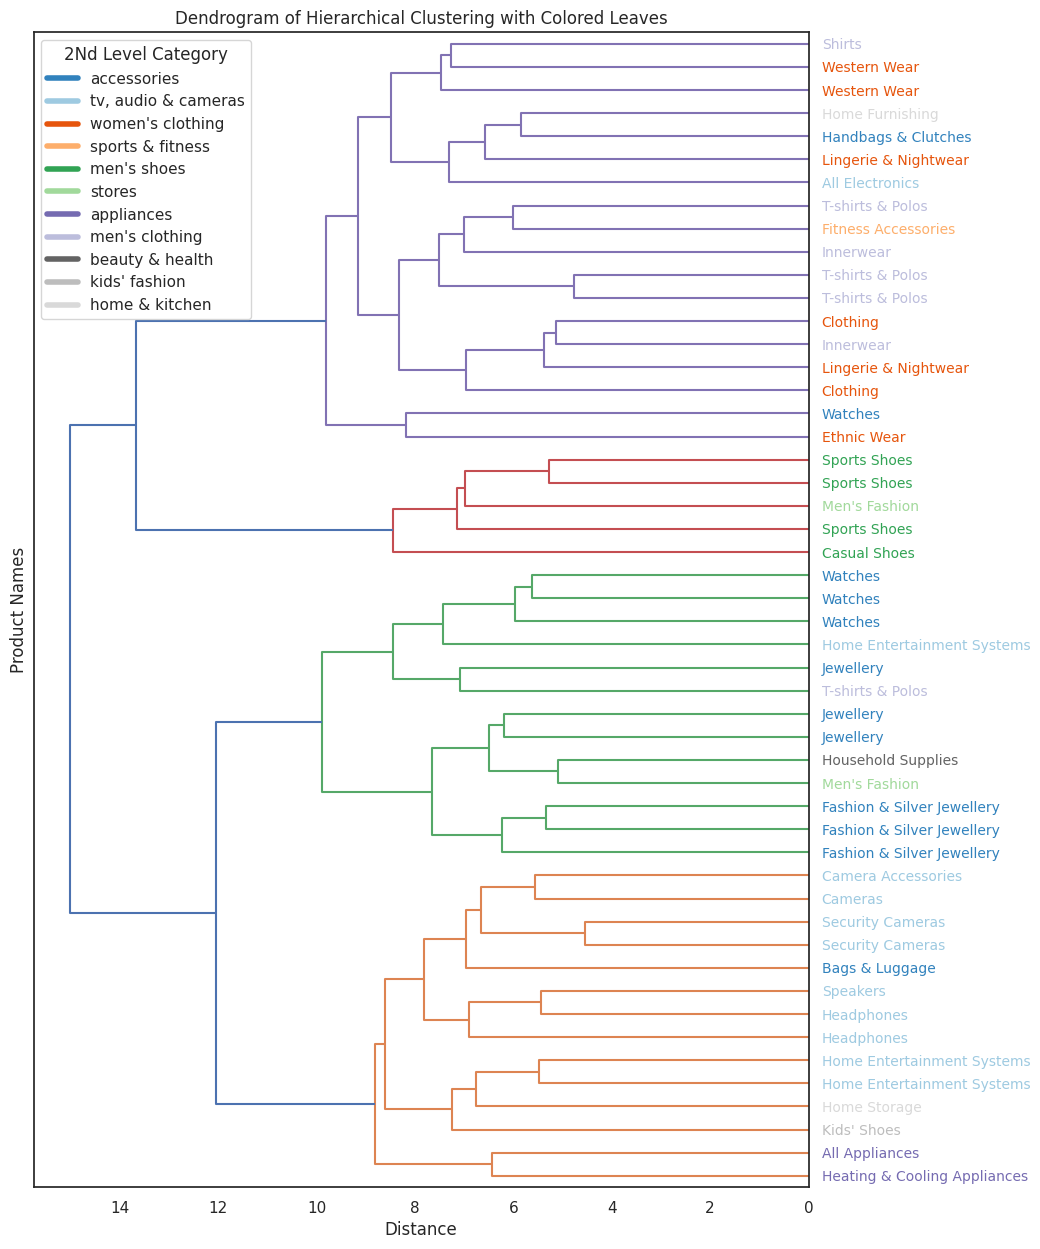

In [21]:
#We can state on which level we want to see colors, and on which level we want to see the text
metrics, linkage_matrix = evaluate_clustering(df_sampled, "bert", None, "3rd_level_category")

text_by_level = "3rd_level_category"
color_by_level = "2nd_level_category"

fig = colored_dendrogram(df_sampled, linkage_matrix, text_by_level, color_by_level)
plt.savefig(f"{FIGS_PATH}/dend_bert.png", transparent=True)
plt.show()

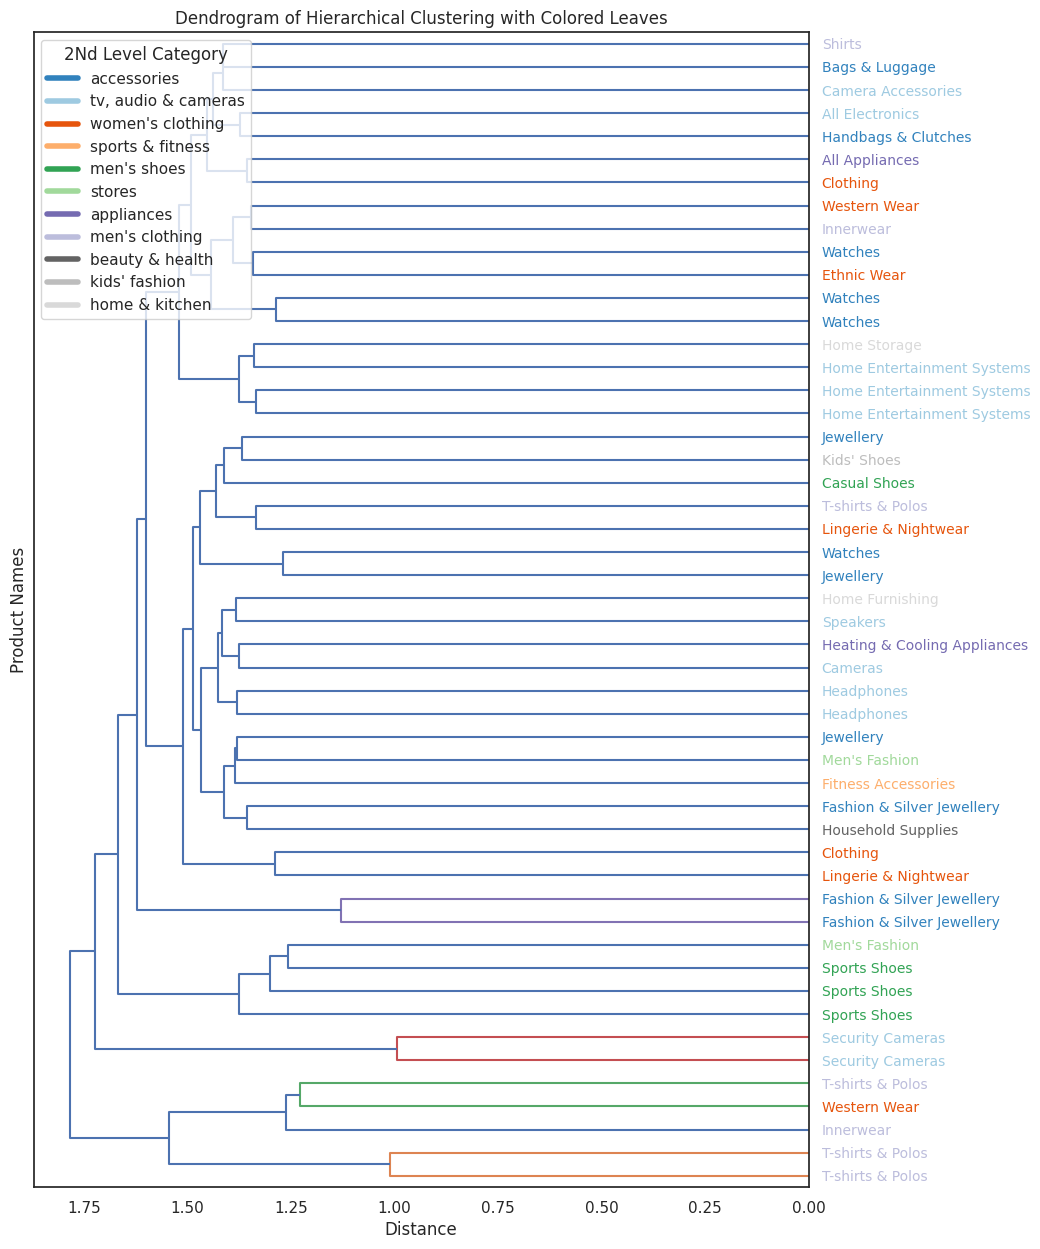

In [22]:
metrics, linkage_matrix = evaluate_clustering(df_sampled, "tf-idf", None, "3rd_level_category")

text_by_level = "3rd_level_category"
color_by_level = "2nd_level_category"


fig = colored_dendrogram(df_sampled, linkage_matrix, text_by_level, color_by_level)
plt.savefig(f"{FIGS_PATH}/dend_tf_idf.png", transparent=True)
plt.show()


We can clearly see that indeed the bert model have much better clustering results.